# Maximizing Predictive Performance in ML Classification Tasks

This notebook presents a complete ML pipeline to compare and optimize classification models on a structured dataset.

A dataset is explored to find the best machine learning model for predicting the target variable `y`. It includes data loading, preprocessing, model training, cross-validation, and performance evaluation for various algorithms.

The goal is to demonstrate effective model comparison and reasoning in selecting the best-performing model.


## Dependencies

This notebook requires the following Python packages:

| Library        | Alias | Purpose                      |
|----------------|-------|------------------------------|
| `pandas`       | `pd`  | Data manipulation            |
| `numpy`        | `np`  | Numerical operations         |
| `scikit-learn` | —     | ML models, preprocessing     |
| `matplotlib`   | `plt` | Plotting                     |
| `seaborn`      | `sns` | Visualization                |
| `optuna`       | —     | Hyperparameter tuning        |
| `xgboost`      | —     | Boosting classifiers         |
| `lightgbm`     | —     | Boosting classifiers         |


In [ ]:
# Run this cell in Google Colab or fresh environments
!pip install pandas numpy scikit-learn matplotlib seaborn optuna xgboost lightgbm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from optuna.integration import XGBoostPruningCallback

In [ ]:
!pip install optuna

## 1. Data Access via Google Drive

To work with the dataset in a Google Colab environment, I first mount Google Drive.  
This allows me to access files stored in a personal Google Drive folder.

> Note: If you're running this notebook locally, replace the Drive path with a local file path.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# Update this path to match your Google Drive folder structure
data_path = "path/to/your/data/"

## 2. Data Loading

In this section, I load the dataset into a pandas DataFrame.

The data is assumed to be in `.csv` format and stored either in Google Drive (for Colab users) or locally (for offline use).

> Tip: Ensure the dataset file name is correct and that the file is uploaded or accessible from your environment.

In [ ]:
# Read CSV while skipping the first column
df = pd.read_csv(data_path + "TrainOnMe.csv", index_col=0)  # Drops the first column

# Preview the data
print(df.head())
print(df.columns)

           y         x1       x2         x3       x4         x5         x6  \
0  Antrophic  199.84675 -0.22935  -94.57266 -0.90297  229.65733 -119.73784   
1     OpenAI  199.76663  0.57961  -98.69548 -0.89087  229.58771 -117.92856   
2  Antrophic  200.40804 -0.03834  -97.64719 -0.89971  230.20797 -121.71234   
3  Antrophic  201.38523  0.51942 -105.16820 -0.89226  231.15781 -120.69422   
4     OpenAI  199.60130 -0.76663  -94.42670 -0.88284  229.39822 -122.24543   

   x7       x8       x9       x10      x11   x12        x13  
0  Q4  0.12045  0.50670  13.31960  2.86055  True  951.94743  
1  Q4 -0.28505  0.16832  14.52734 -0.51453  True  949.48540  
2  Q3 -0.13753  0.71530   9.90651  0.35612  True  953.21660  
3  Q2  0.03872 -0.37550  11.10684  1.32156  True  954.34203  
4  Q4  0.46721  2.14220   9.72683 -4.96100  True  950.79316  
Index(['y', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13'],
      dtype='object')


## 3. Initial Preprocessing

In this step, I prepare the dataset for modeling by transforming categorical and binary variables, separating features from the target, and standardizing the inputs.

These preprocessing steps are essential to ensure that the machine learning models receive clean, properly formatted data.


In [ ]:
# Identify categorical and binary columns (excluding the target 'y')
categorical_col = 'x7'
binary_col = 'x12'  # Binary column

# Separate target variable from features
y = df['y']
X = df.drop(columns=['y'])

# Convert binary column (True/False) to integers (1/0)
X[binary_col] = X[binary_col].astype(int)

# One-hot encode the categorical feature (x7)
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_X = encoder.fit_transform(X[['x7']])
encoded_X_df = pd.DataFrame(encoded_X, columns=encoder.get_feature_names_out(['x7']))

# Drop original categorical column and add encoded features
X = X.drop(columns=['x7']).reset_index(drop=True)
X = pd.concat([X, encoded_X_df], axis=1)

# Label-encode the target variable 'y' for classification
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Standardize numerical features (after encoding is complete)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 4. Feature Engineering & Splitting
After preprocessing, I split the dataset into training and test sets using stratified sampling to preserve the class distribution.

I also visualize the class balance in the training data, which is an important step before applying any resampling techniques (e.g., SMOTE) or training models.

> Class imbalance, if present, can impact model performance and must be handled appropriately.

In [ ]:
# Split the data into training and test sets (80/20 split), stratifying by target class
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y)

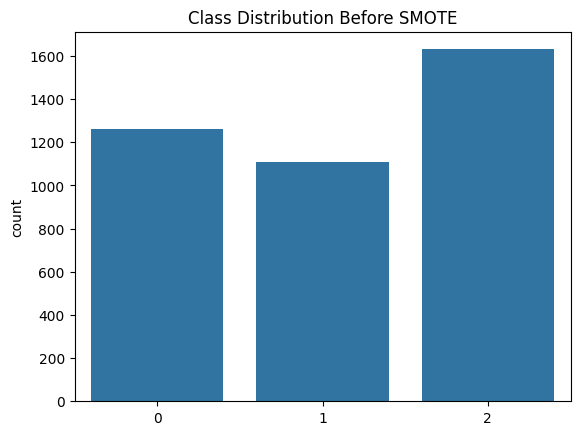

In [ ]:
# Visualize class distribution in the training set
sns.countplot(x=y_train)
plt.title("Class Distribution Before SMOTE")
plt.show()

## 5. Hyperparameter Optimization for Classifiers

I define and optimize three classification models: **Random Forest**, **XGBoost**, and **LightGBM**.

Using `Optuna`, I tune each model’s hyperparameters to maximize classification accuracy. Each optimization uses cross-validation for evaluation, and pruning is enabled to efficiently skip unpromising trials.

> This approach demonstrates practical experience in model selection, tuning, and reproducibility in real-world ML workflows.



In [ ]:
# Random Forest Objective Function for Optuna
def rf_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 600, step=50)
    max_depth = trial.suggest_int('max_depth', 5, 30, step=2)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42
    )

    return cross_val_score(rf, X_train, y_train, cv=10, scoring='accuracy').mean()

# Run Optuna study for RF
rf_study = optuna.create_study(direction="maximize")
rf_study.optimize(rf_objective, n_trials=50, n_jobs=-1)

print("Best RF Parameters:", rf_study.best_params)

### Best Random Forest Parameters (Optuna Result)

- `n_estimators`: 600  
- `max_depth`: 15  
- `min_samples_split`: 12  
- `min_samples_leaf`: 2  
- `max_features`: "log2"  
- `bootstrap`: True  
- **Cross-validated Accuracy**: 0.68750

In [ ]:
# XGBoost Objective Function for Optuna
def xgb_objective(trial):
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-logloss")

    n_estimators = trial.suggest_int('n_estimators', 100, 500, step=50)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)

    xgb = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        random_state=42,
        eval_metric="logloss",
        tree_method="gpu_hist",  # GPU acceleration
        gpu_id=0
    )

    scores = cross_val_score(xgb, X_train, y_train, cv=3, scoring="accuracy")

    trial.report(scores.mean(), step=0)

    if trial.should_prune():
        raise optuna.TrialPruned()

    return scores.mean()

# Run Optuna study for XGBoost
xgb_study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
xgb_study.optimize(xgb_objective, n_trials=30, n_jobs=-1)

print("Best XGB Parameters:", xgb_study.best_params)

### Best XGBoost Parameters (Optuna Result)

- `n_estimators`: 550  
- `max_depth`: 8  
- `learning_rate`: 0.2051686949233296
- `subsample`: 0.5060864147463304
- `colsample_bytree`: 0.8061335924872397
- `gamma`: 4.069312272904837
- **Cross-validated Accuracy**: 0.69025

In [ ]:
# LightGBM Objective Function for Optuna
def lgb_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 300, step=50)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    num_leaves = trial.suggest_int('num_leaves', 20, 100)  # Reduced range
    min_child_samples = trial.suggest_int('min_child_samples', 5, 50)  # Smaller range
    lambda_l1 = trial.suggest_float('lambda_l1', 0, 2)  # Reduced range
    lambda_l2 = trial.suggest_float('lambda_l2', 0, 2)

    lgb = LGBMClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        lambda_l1=lambda_l1,
        lambda_l2=lambda_l2,
        random_state=42
    )

    return cross_val_score(lgb, X_train, y_train, cv=5, scoring='accuracy').mean()  # 5-Fold CV for speed

# Run Optuna study for LGBM
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
lgb_study = optuna.create_study(direction="maximize", pruner=pruner)
lgb_study.optimize(lgb_objective, n_trials=30, n_jobs=-1)

print("Best LGB Parameters:", lgb_study.best_params)

### Best LightGBM Parameters (Optuna Result)

- `n_estimators`: 100   
- `learning_rate`: 0.021759151111545517
- `num_leaves`: 42
- `min_child_samples`: 18
- `lambda_l1`: 0.3271237462768151
- `lambda_l2`: 0.8711423014282733
- **Cross-validated Accuracy**: 0.67950

## 6. Stacked Ensemble Evaluation (Model Comparison)

In this section, I compare various final estimators within a stacked ensemble using optimized base models:

- Base models: tuned **Random Forest**, **XGBoost**, and **LightGBM**
- Final estimators tested: **Logistic Regression**, **XGBoost**, **Random Forest**, and **LightGBM**

Each stacking configuration is evaluated using accuracy on the test set.  
This comparison helps identify which final estimator performs best before selecting a final ensemble.

> The selected configuration in the next section is used to make final predictions on unseen data.

In [ ]:
# Initialize base models using best hyperparameters found via Optuna
best_rf = RandomForestClassifier(**rf_study.best_params, random_state=42)
best_xgb = XGBClassifier(**xgb_study.best_params, random_state=42, eval_metric="logloss")
best_lgb = LGBMClassifier(**lgb_study.best_params, random_state=42)

# Define different models to test as the final estimator in a stacking ensemble
final_estimators = {
    "LogisticRegression": LogisticRegression(),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=42),
}

# Evaluate each stacking configuration with different final estimators
for name, estimator in final_estimators.items():
    # Create stacking classifier with fixed base models and a variable final estimator
    stacking_model = StackingClassifier(
        estimators=[('rf', best_rf), ('xgb', best_xgb), ('lgb', best_lgb)],
        final_estimator=estimator,
        cv=5
    )
    
    # Train the stacking model
    stacking_model.fit(X_train, y_train)
    
    # Predict on the test set and evaluate accuracy
    y_pred = stacking_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Stacking Accuracy with {name}: {acc:.4f}")

### Stacked Ensemble Results

I evaluated different final estimators for a stacking classifier using cross-validated accuracy:

<table>
<tr><td><code>LogisticRegression</code></td><td><strong>0.7040</strong></td></tr>
<tr><td><code>RandomForest</code></td><td><strong>0.7010</strong></td></tr>
<tr><td><code>XGBoost</code></td><td><strong>0.6930</strong></td></tr>
<tr><td><code>LightGBM</code></td><td><strong>0.6880</strong></td></tr>
</table>
&nbsp;

> Based on this evaluation, I selected **LogisticRegression** as the final estimator for the stacking model.

## 7. Final Ensemble Selection & Evaluation

Based on the model comparison in Section 6, I select the final stacking model with `LogisticRegression` as the final estimator.

I retrain the stacking ensemble on the full training data and evaluate its accuracy on the test set to finalize my model selection.

In [ ]:
# Define final stacking model using Logistic Regression as final estimator
final_stacking = StackingClassifier(
    estimators=[('rf', best_rf), ('xgb', best_xgb), ('lgb', best_lgb)],
    final_estimator=LogisticRegression(),
    cv=10
)

# Train the final ensemble on the full training set
final_stacking.fit(X_train, y_train)

# Evaluate final model on test set
y_pred = final_stacking.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Final Stacking Accuracy:", accuracy)

## 8. Predicting on New Data

In this section, I use the final trained stacking model to make predictions on unseen data (`EvaluateOnMe.csv`).

The new data undergoes the same preprocessing pipeline as the training data.  
The output predictions are saved as a CSV file for downstream use, emulating a real-world model deployment pipeline.

In [ ]:
# Load unseen test data
new_data = pd.read_csv(data_path + "EvaluateOnMe.csv", index_col=0)

# Preprocess new data using the same steps as training data

# Encode binary column (True/False → 1/0)
new_data[binary_col] = new_data[binary_col].astype(int)

# One-hot encode the categorical column (x7)
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_new_data = encoder.fit_transform(new_data[['x7']])
encoded_new_data = pd.DataFrame(encoded_new_data, columns=encoder.get_feature_names_out(['x7']))

# Replace original categorical column with one-hot version
new_data = new_data.drop(columns=['x7']).reset_index(drop=True)
new_data = pd.concat([new_data, encoded_new_data], axis=1)

# Apply standard scaling to match training distribution
scaler = StandardScaler()
new_data_scaled = scaler.fit_transform(new_data)

# Generate predictions
predicted_labels_encoded = final_stacking.predict(new_data_scaled)
predicted_labels = label_encoder.inverse_transform(predicted_labels_encoded)

# Save predictions as a CSV file
pd.DataFrame(predicted_labels).to_csv("predictions.csv", index=False, header=False)

print("Predictions saved as predictions.csv")

## 9. Conclusion

This notebook demonstrated a full machine learning classification workflow:

- Explored and preprocessed data with categorical and binary features
- Tuned hyperparameters for **Random Forest**, **XGBoost**, and **LightGBM** using `Optuna`
- Compared stacked ensemble performance with multiple final estimators
- Selected a final stacking model with **Logistic Regression** based on test accuracy
- Applied the trained model to make predictions on unseen data

> This end-to-end pipeline reflects a real-world ML workflow, balancing model performance, interpretability, and reproducibility.

